# Evaluating Driver's Delivery Efficiency

In this notebook, we train corresponding neural networks to analyze the delivery data. In the first model, we predict delivery time used based on weather, distance, and driver's information etc. In the second model, we use delivery data to predict the driver's information, so that we may evalute driver's perfomance using historical data. In the third model, I build a neural network with multiple outputs, e.g. driver's experience and driver safety incidents. 

I think evaluating each driver's delivery ability is an important factor we need to consider for saving money. When we know each driver's ability, we could optimize the delivery arrangement based on that. Also knowning about frequency of incidents will help us avoid possible losses by adjusting corresponding affecting factors. 

## Contents.

- [ 1 - Data Preparation ](#1)
- [ 2 - Predict Delivery Time using Given Factors ](#2)
- [ 3 - Predict Driver's Experience based on Delivery Performance](#3)
- [ 4 - Multiple Predictions](#4)
- [ 5 - Further Comments: Combining Delivery Assignment with Performance Evaluation](#5)


<a name="1"></a>
## 1. Data Prepration

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

Read our data from csv file

In [2]:
data = pd.read_csv(r'delivery cats.csv')

In [3]:
print(data.shape)
data.head(10)

(1000, 8)


,DeliveryTime,NumberPackagesDelivered,Temperature,DistanceToCityCenterFromDC,DriverExperience,DriverSafetyIncidents,VehicleType,FulfillmentChannel
0,6.7,110,61.9,32.0,13.2,3,Gas,SFS
1,6.1,96,42.3,30.7,12.7,2,Gas,SFS
2,2.6,94,40.6,30.3,13.7,4,Gas,SFDC
3,7.5,98,57.2,33.7,8.3,4,Electric,SFS
4,3.4,99,61.4,28.3,13.7,4,Gas,SFS
5,7.1,100,75.6,33.2,6.7,6,Gas,SFDC
6,3.4,97,48.7,25.4,10.6,7,Electric,SFS
7,4.7,111,51.1,25.4,16.2,2,Electric,SFS
8,7.2,101,62.1,21.8,9.5,3,Gas,SFDC
9,3.5,96,49.4,23.4,13.7,6,Gas,SFS


We can see that "DeliveryTime" (time needed to finish the delivery) the depends on various factors, such as number of packages, temperature, travel distances, driver's experience etc. Since we want to do calculations on these factors, we change "Vehicle Type" and "FulfillmentChannel" to numbers,

                                         0: Gas, 1: Electric
                                         0: SFS, 1: SFDC

In [4]:
data['VehicleType'] = 1*(data['VehicleType']=='Electric')
data['FulfillmentChannel'] = 1*(data['FulfillmentChannel']=='SFDC')

In [5]:
print(data.shape)
data.head(10)

(1000, 8)


,DeliveryTime,NumberPackagesDelivered,Temperature,DistanceToCityCenterFromDC,DriverExperience,DriverSafetyIncidents,VehicleType,FulfillmentChannel
0,6.7,110,61.9,32.0,13.2,3,0,0
1,6.1,96,42.3,30.7,12.7,2,0,0
2,2.6,94,40.6,30.3,13.7,4,0,1
3,7.5,98,57.2,33.7,8.3,4,1,0
4,3.4,99,61.4,28.3,13.7,4,0,0
5,7.1,100,75.6,33.2,6.7,6,0,1
6,3.4,97,48.7,25.4,10.6,7,1,0
7,4.7,111,51.1,25.4,16.2,2,1,0
8,7.2,101,62.1,21.8,9.5,3,0,1
9,3.5,96,49.4,23.4,13.7,6,0,0


In [6]:
print("The number of vehicles using gas is:", np.sum(1-data['VehicleType']))
print("The number of vehicles using electric is:", np.sum(data['VehicleType']))

The number of vehicles using gas is: 747
The number of vehicles using electric is: 253


In [7]:
print("The number of Fullfilment Channel with SFS is:", np.sum(1-data['FulfillmentChannel']))
print("The number of Fullfilment Channel with SFDC is:", np.sum(data['FulfillmentChannel']))

The number of Fullfilment Channel with SFS is: 524
The number of Fullfilment Channel with SFDC is: 476


<a name="2"></a>
## 2. Predict Delivery Time using Given Factors

In this section, we would like to build a neural network to predict delievery times given number of packages, distance, temparature, driver's experience etc. 

In [8]:
X = data.iloc[:,1:].to_numpy()
y = data.loc[:,['DeliveryTime']].to_numpy()
print("X.shape", X.shape, "y.shape", y.shape)

X.shape (1000, 7) y.shape (1000, 1)


In [9]:
X[:10]

array([[110. ,  61.9,  32. ,  13.2,   3. ,   0. ,   0. ],
       [ 96. ,  42.3,  30.7,  12.7,   2. ,   0. ,   0. ],
       [ 94. ,  40.6,  30.3,  13.7,   4. ,   0. ,   1. ],
       [ 98. ,  57.2,  33.7,   8.3,   4. ,   1. ,   0. ],
       [ 99. ,  61.4,  28.3,  13.7,   4. ,   0. ,   0. ],
       [100. ,  75.6,  33.2,   6.7,   6. ,   0. ,   1. ],
       [ 97. ,  48.7,  25.4,  10.6,   7. ,   1. ,   0. ],
       [111. ,  51.1,  25.4,  16.2,   2. ,   1. ,   0. ],
       [101. ,  62.1,  21.8,   9.5,   3. ,   0. ,   1. ],
       [ 96. ,  49.4,  23.4,  13.7,   6. ,   0. ,   0. ]])

In [10]:
 y[:10]

array([[6.7],
       [6.1],
       [2.6],
       [7.5],
       [3.4],
       [7.1],
       [3.4],
       [4.7],
       [7.2],
       [3.5]])

In order to do a better performance in our neural network training, we normalize our data first.

In [11]:
# scale training data
X_unscaled = X
y_unscaled = y
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y.reshape(-1, 1))
y = scalerTarget.transform(y.reshape(-1, 1))

print(np.allclose(X_unscaled, scaler.inverse_transform(X)))

True


Now we split the data into Train set and Test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (800, 7) y_train.shape (800, 1)
X_test.shape (200, 7) y_test.shape (200, 1)


Here we build a neural network.

In [13]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

model = Sequential(
    [
        Dense(200, activation='relu', name='L1'),
        Dense(60, activation='relu', name='L2'),
        Dense(1, activation= 'linear', name='L3')
    ], name="DelieveryTime"
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [14]:
model.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
25/25 [==============================] - 1s 2ms/step - loss: 0.0791
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0362
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 13/1000
25/25 [====

25/25 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 105/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 106/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 107/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 109/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 113/1000
25/2

25/25 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 301/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 307/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 309/1000
25/2

25/25 [==============================] - 0s 2ms/step - loss: 8.7278e-04
Epoch 494/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.5193e-04
Epoch 495/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 496/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 497/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 498/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 499/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 500/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 501/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 502/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 503/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 504/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 505/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 688/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 689/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 690/1000
25/25 [==============================] - 0s 2ms/step - loss: 9.9348e-04
Epoch 691/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.9067e-04
Epoch 692/1000
25/25 [==============================] - 0s 2ms/step - loss: 9.7338e-04
Epoch 693/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.7731e-04
Epoch 694/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.9158e-04
Epoch 695/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 696/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 697/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 698/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0033

25/25 [==============================] - 0s 2ms/step - loss: 8.2806e-04
Epoch 880/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 881/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 882/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 883/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 884/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 885/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 886/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 887/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 888/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 889/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 890/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 891/1000


We define a function to estimate the prediction error. 

In [15]:
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err+=(yhat[i]-y[i])**2
     
    err=err/(2*m)
    return(err)

Make the prediction and check the error.

In [16]:
yhat = model.predict(X_test)
print('The mean sequare error is', eval_mse(y_test, yhat))

7/7 [==============================] - 0s 2ms/step
The mean sequare error is [0.04157692]


In [17]:
yhat[:10]

array([[-0.5279612 ],
       [-0.82412285],
       [-0.8040172 ],
       [ 0.3836568 ],
       [ 0.20049053],
       [-0.33621883],
       [-0.03684079],
       [-0.4332005 ],
       [ 0.08875675],
       [-0.36270803]], dtype=float32)

We plot predictions and real values on the test set. First we unscale the prediction results. 

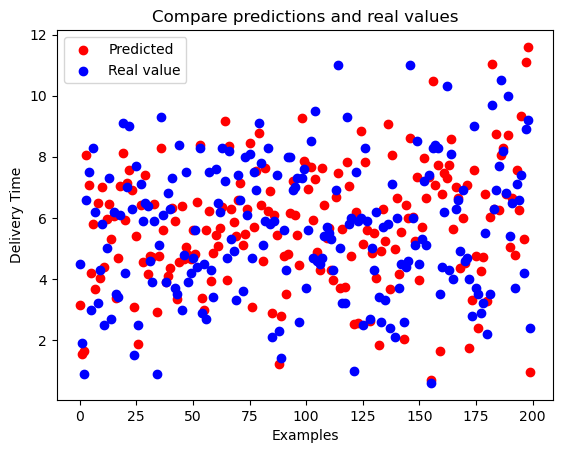

In [18]:
yhat_unscaled = scalerTarget.inverse_transform(yhat)
y_test_unscaled = scalerTarget.inverse_transform(y_test)

plt.title("Compare predictions and real values")
plt.xlabel("Examples")
plt.ylabel("Delivery Time")

x_data = list(range(len(yhat)))
plt.scatter(x_data, yhat_unscaled, color="red", label='Predicted')
plt.scatter(x_data, y_test_unscaled,color='blue', label='Real value')
plt.legend()
plt.show()

<a name="3"></a>
## 3. Predict Driver's Experience based on Delivery Performance

In this section, we train a neural network to study the driver's experience so that we could use to evaluate their delivery efficiency. 

First we prepare the data for our training. 

In [19]:
y_driver = data[['DriverExperience']].to_numpy()
X_driver = data.drop(columns=['DriverExperience']).to_numpy()

In [20]:
X_driver[:10]

array([[  6.7, 110. ,  61.9,  32. ,   3. ,   0. ,   0. ],
       [  6.1,  96. ,  42.3,  30.7,   2. ,   0. ,   0. ],
       [  2.6,  94. ,  40.6,  30.3,   4. ,   0. ,   1. ],
       [  7.5,  98. ,  57.2,  33.7,   4. ,   1. ,   0. ],
       [  3.4,  99. ,  61.4,  28.3,   4. ,   0. ,   0. ],
       [  7.1, 100. ,  75.6,  33.2,   6. ,   0. ,   1. ],
       [  3.4,  97. ,  48.7,  25.4,   7. ,   1. ,   0. ],
       [  4.7, 111. ,  51.1,  25.4,   2. ,   1. ,   0. ],
       [  7.2, 101. ,  62.1,  21.8,   3. ,   0. ,   1. ],
       [  3.5,  96. ,  49.4,  23.4,   6. ,   0. ,   0. ]])

Normalize the data.

In [21]:
X_driver_unscaled = X_driver
y_driver_unscaled = y_driver

scalerDriver = StandardScaler()
scalerDriver.fit(X_driver)
X_driver = scalerDriver.transform(X_driver)

scalerDriverTarget = MinMaxScaler((-1, 1))
scalerDriverTarget.fit(y_driver.reshape(-1, 1))
y_driver = scalerDriverTarget.transform(y_driver.reshape(-1, 1))

print(np.allclose(X_driver_unscaled, scalerDriver.inverse_transform(X_driver)))

True


Split the train set and test set.

In [22]:
X_driver_train, X_driver_test, y_driver_train, y_driver_test = train_test_split(X_driver,y_driver,test_size=0.20, random_state=1)
print("X_driver_train.shape", X_driver_train.shape, "y_driver_train.shape", y_driver_train.shape)
print("X_driver_test.shape", X_driver_test.shape, "y_driver_test.shape", y_driver_test.shape)

X_driver_train.shape (800, 7) y_driver_train.shape (800, 1)
X_driver_test.shape (200, 7) y_driver_test.shape (200, 1)


In [23]:
y_driver_train[:10]

array([[-0.38755981],
       [-0.1291866 ],
       [-0.11004785],
       [-0.22488038],
       [-0.0430622 ],
       [-0.02392344],
       [-0.13875598],
       [ 0.32057416],
       [ 0.01435407],
       [-0.16746411]])

Build a corresponding neural network.

In [24]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

driver_model = Sequential(
    [
        Dense(200, activation='relu', name='L1'),
        Dense(60, activation='relu', name='L2'),
        Dense(1, activation= 'linear', name='L3')
    ], name="DriversExperience"
)
driver_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

Train the model.

In [25]:
driver_model.fit(
    X_driver_train, y_driver_train,
    epochs=1000
)

Epoch 1/1000
25/25 [==============================] - 1s 2ms/step - loss: 0.0588
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 13/1000
25/25 [====

25/25 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 113/1000
25/2

25/25 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 301/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 309/1000
25/2

Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 9.4001e-04
Epoch 398/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 399/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 400/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 401/1000
25/25 [==============================] - 0s 2ms/step - loss: 9.0361e-04
Epoch 402/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.9206e-04
Epoch 403/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.6722e-04
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - l

25/25 [==============================] - 0s 2ms/step - loss: 8.8349e-04
Epoch 590/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 591/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 592/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 593/1000
25/25 [==============================] - 0s 2ms/step - loss: 9.3057e-04
Epoch 594/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.0200e-04
Epoch 595/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.6476e-04
Epoch 596/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.1729e-04
Epoch 597/1000
25/25 [==============================] - 0s 2ms/step - loss: 5.6045e-04
Epoch 598/1000
25/25 [==============================] - 0s 2ms/step - loss: 6.8406e-04
Epoch 599/1000
25/25 [==============================] - 0s 3ms/step - loss: 6.9942e-04
Epoch 600/1000
25/25 [==============================] - 0s 2ms/step - 

25/25 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 783/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 784/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 785/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 786/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 787/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 788/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.7711e-04
Epoch 789/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.8939e-04
Epoch 790/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 791/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 792/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.6874e-04
Epoch 793/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 4.3690e-04
Epoch 879/1000
25/25 [==============================] - 0s 2ms/step - loss: 4.0860e-04
Epoch 880/1000
25/25 [==============================] - 0s 2ms/step - loss: 6.7901e-04
Epoch 881/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 882/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 883/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 884/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 885/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 886/1000
25/25 [==============================] - 0s 2ms/step - loss: 8.1623e-04
Epoch 887/1000
25/25 [==============================] - 0s 1ms/step - loss: 5.2533e-04
Epoch 888/1000
25/25 [==============================] - 0s 2ms/step - loss: 6.4470e-04
Epoch 889/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.

Predict the driver's experience, and check the error. 

In [26]:
yhat_driver = driver_model.predict(X_driver_test)
print('The mean sequare error is', eval_mse(y_driver_test, yhat_driver))

7/7 [==============================] - 0s 1ms/step
The mean sequare error is [0.03249862]


Plot and compare the predictions. 

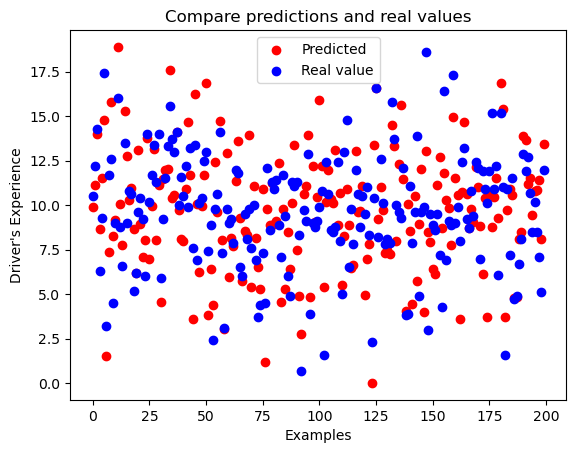

In [27]:
yhat_driver_unscaled = scalerDriverTarget.inverse_transform(yhat_driver)
y_driver_test_unscaled = scalerDriverTarget.inverse_transform(y_driver_test)

plt.title("Compare predictions and real values")
plt.xlabel("Examples")
plt.ylabel("Driver's Experience")

x_driver_data = list(range(len(yhat_driver)))
plt.scatter(x_driver_data, yhat_driver_unscaled, color="red", label='Predicted')
plt.scatter(x_driver_data, y_driver_test_unscaled,color='blue', label='Real value')
plt.legend()
plt.show()

<a name='4'> </a>
## 4. Multiple Predictions

We may use our data to predict both "Driver's Experience" and "Driver Safety Incidents" simultaneouly. 

In [28]:
y_multi = data[['DriverExperience', 'DriverSafetyIncidents']].to_numpy()
X_multi = data.drop(columns=['DriverExperience', 'DriverSafetyIncidents']).to_numpy()

In [29]:
y_multi[:10]

array([[13.2,  3. ],
       [12.7,  2. ],
       [13.7,  4. ],
       [ 8.3,  4. ],
       [13.7,  4. ],
       [ 6.7,  6. ],
       [10.6,  7. ],
       [16.2,  2. ],
       [ 9.5,  3. ],
       [13.7,  6. ]])

In [30]:
X_multi[:10]

array([[  6.7, 110. ,  61.9,  32. ,   0. ,   0. ],
       [  6.1,  96. ,  42.3,  30.7,   0. ,   0. ],
       [  2.6,  94. ,  40.6,  30.3,   0. ,   1. ],
       [  7.5,  98. ,  57.2,  33.7,   1. ,   0. ],
       [  3.4,  99. ,  61.4,  28.3,   0. ,   0. ],
       [  7.1, 100. ,  75.6,  33.2,   0. ,   1. ],
       [  3.4,  97. ,  48.7,  25.4,   1. ,   0. ],
       [  4.7, 111. ,  51.1,  25.4,   1. ,   0. ],
       [  7.2, 101. ,  62.1,  21.8,   0. ,   1. ],
       [  3.5,  96. ,  49.4,  23.4,   0. ,   0. ]])

Normalize our data. 

In [31]:
X_multi_unscaled = X_multi
y_multi_unscaled = y_multi

scalerMulti = StandardScaler()
scalerMulti.fit(X_multi)
X_multi = scalerMulti.transform(X_multi)

scalerMultiTarget = MinMaxScaler((-1, 1))
scalerMultiTarget.fit(y_multi)
y_multi = scalerMultiTarget.transform(y_multi)

print(np.allclose(X_multi_unscaled, scalerMulti.inverse_transform(X_multi)))

True


Split train set and test set. 

In [32]:
X_multi_train, X_multi_test, y_multi_train, y_multi_test= train_test_split(X_multi,y_multi,test_size=0.10, random_state=1)
print("X_multi_train.shape", X_multi_train.shape, "y_multi_train.shape", y_multi_train.shape)
print("X_multi_test.shape", X_multi_test.shape, "y_multi_test.shape", y_multi_test.shape)

X_multi_train.shape (900, 6) y_multi_train.shape (900, 2)
X_multi_test.shape (100, 6) y_multi_test.shape (100, 2)


Build a neural network model. 

In [33]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

multi_model = Sequential(
    [
        Dense(500, activation='relu', name='L1'),
        Dense(200, activation='relu', name='L2'),
        Dense(40, activation= 'relu', name='L3'),
        Dense(2, activation= 'linear', name='L4')
    ], name="MultipleOutputs"
)
multi_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

Train the network. 

In [34]:
multi_model.fit(
    X_multi_train, y_multi_train,
    epochs=1000
)

Epoch 1/1000
29/29 [==============================] - 1s 4ms/step - loss: 0.0961
Epoch 2/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0808
Epoch 3/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0790
Epoch 4/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0776
Epoch 5/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0746
Epoch 6/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0770
Epoch 7/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 8/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0708
Epoch 9/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0704
Epoch 10/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 11/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0692
Epoch 12/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 13/1000
29/29 [====

29/29 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 102/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 103/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 104/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 105/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 106/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 107/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 108/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 109/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 110/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 111/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 112/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 113/1000
29/2

29/29 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 298/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 299/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 300/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 301/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 302/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 303/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 304/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 305/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 306/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 307/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 308/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 309/1000
29/2

29/29 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 494/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 495/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 496/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 497/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 498/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 499/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 500/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 501/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 502/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 503/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 504/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 505/1000
29/2

29/29 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 690/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 691/1000
29/29 [==============================] - 0s 3ms/step - loss: 9.3937e-04
Epoch 692/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 693/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 694/1000
29/29 [==============================] - 0s 3ms/step - loss: 9.1365e-04
Epoch 695/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 696/1000
29/29 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 697/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 698/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 699/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 700/1000
29/29 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 701/1

29/29 [==============================] - 0s 3ms/step - loss: 5.8025e-04
Epoch 886/1000
29/29 [==============================] - 0s 3ms/step - loss: 4.8549e-04
Epoch 887/1000
29/29 [==============================] - 0s 3ms/step - loss: 3.9089e-04
Epoch 888/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.9041e-04
Epoch 889/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.1043e-04
Epoch 890/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.3607e-04
Epoch 891/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.2445e-04
Epoch 892/1000
29/29 [==============================] - 0s 3ms/step - loss: 1.8231e-04
Epoch 893/1000
29/29 [==============================] - 0s 3ms/step - loss: 1.6439e-04
Epoch 894/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.0649e-04
Epoch 895/1000
29/29 [==============================] - 0s 3ms/step - loss: 2.2405e-04
Epoch 896/1000
29/29 [==============================] - 0s

Make the predictions. 

In [35]:
yhat_multi = multi_model.predict(X_multi_test)

4/4 [==============================] - 0s 3ms/step


In [36]:
yhat_multi[:10]

array([[-0.49924412, -0.01682877],
       [-0.02486293, -0.17267996],
       [ 0.29467192, -0.01322242],
       [-0.06454247,  0.04513157],
       [ 0.04663345, -0.0594159 ],
       [ 0.04872467,  0.44808754],
       [-0.36592227, -0.16188356],
       [ 0.10718217, -0.31091297],
       [ 0.45100424, -0.47776023],
       [-0.30189645, -0.24088314]], dtype=float32)

We plot "Driver's Experience" and "Driver Safety Incidents" separately. 

First we unscale our results. 

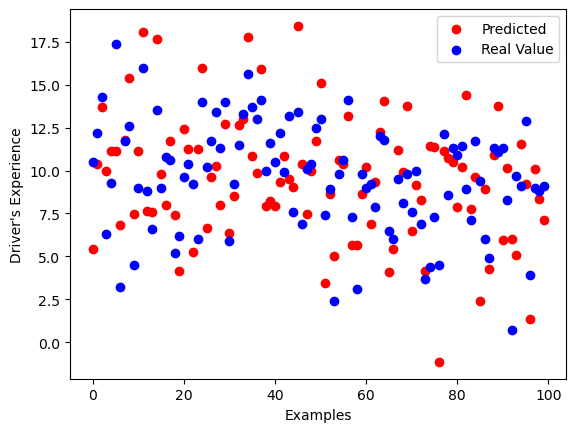

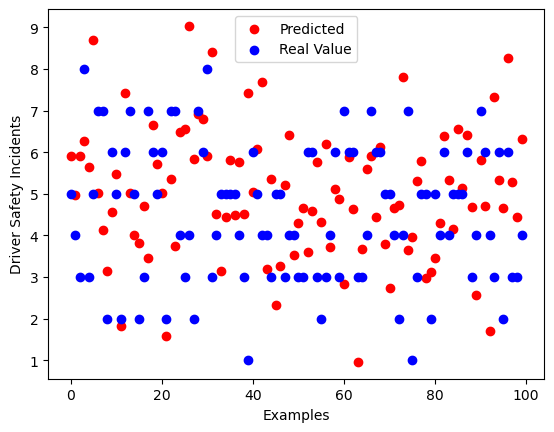

In [37]:
yhat_multi_unscaled = scalerMultiTarget.inverse_transform(yhat_multi)
y_multi_test_unscaled = scalerMultiTarget.inverse_transform(y_multi_test)

x_multi_data = list(range(len(yhat_multi)))
experience = yhat_multi_unscaled[:,0]
safety = yhat_multi_unscaled[:,1]
experience_test = y_multi_test_unscaled[:,0]
safety_test = y_multi_test_unscaled[:,1]

plt.scatter(x_multi_data, experience, color="red", label='Predicted')
plt.scatter(x_multi_data, experience_test, color="blue", label='Real Value')
plt.xlabel("Examples")
plt.ylabel("Driver's Experience")

plt.legend()
plt.show()

plt.scatter(x_multi_data, safety, color="red", label='Predicted')
plt.scatter(x_multi_data, safety_test, color="blue", label='Real Value')
plt.xlabel("Examples")
plt.ylabel("Driver Safety Incidents")

plt.legend()
plt.show()

<a name="5"></a>
## 5. Further Comments: Combining Delivery Assignment with Performance Evaluation

In last notebook, I designed a strategy to assign delivery works based on driver's performance. In this notebook, we use historical data to evaluate driver's delivery ability. Therefore, combining these information together might give us a good strategy to optimizie the delivery performance. 